<a href="https://colab.research.google.com/github/Stamateus/Big_Data_Spark/blob/main/Big_Data_Final_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto da Disciplina de Big Data**

## Análise do Perfil de Compras e Comportamento do Consumidor

1 - Descreva o problema ou a dor de negócio que você quer explorar na sua análise.

2 - Quais dados você tem disponível para a análise?

3 - Que hipóteses você pretende validar?

4 - O que você pode concluir de cada uma das análises?



1 - Uma rede de shoppings deseja conhecer melhor os seus clientes, mapear o seu perfil e padrão de consumo. Ela quer entender também se os descontos ou meios de envio impactam a nota de review dos clientes, bem como se o faturamento é impactado pela estação do ano.





2 - Os dados disponíveis são: Idade, gênero, item comprado, categoria do item, valor da compra, localização da loja, tamanho e cor do item, estação do ano em que foi realizada a compra, nota do cliente para o item, tipo de frete, se houve desconto na compra, número de compras anteriores, meio de pagamento e frequência de compra do cliente.

3 - Pretendo validar a hipótese fretes de envio mais rápidos podem impactar a nota de avaliação positivamente, assim como pelo desconto dado, o comprador tende a se sentir mais feliz por ter pago mais barato por um produto. Dado que existem roupas de primavera/verão e outono/inverno, desejo validar que a estação do ano não impacta nas vendas.

4 - O ponto de maior destaque, é a quantidade de clientes do gênero masculino ser o dobro do gênero feminino,isso indica uma oportunidade/análise maior de outros dados. Seria interessante investigar o estado civil, dado que a compra pode ser feita pela esposa e paga com a conta do marido, ou se realmente for menor, ofertar produtos/propagandas voltadas para o público feminino.
  - Descontos e promoções não afetam a avaliação dos clientes, logo a nota está muito mais relacionada ao produto/experiência de compra.
  - O tipo de frete também não afeta a avaliação e a expêriencia do cliente, uma vez que a média e o desvio padrão da entrega mais rápido a mais demorada são muito próximos.
  - A diferença entre o volume de vendas e o faturamento por estação do ano é inferior a 5% da melhor estação para a pior, e inferior a 3% da melhor venda para a segunda melhor, o que valida a hipótese das mudanças de coleção continuarem a atrair os clientes. A pior estação foi o verão, o que leva a uma segunda hipótese que as pessoas precisam vestir menos roupas do que no inverno,comprando menos itens.
  -A rede conseguiu atrair um vasto público considerando a idade, de 20 a 65 anos, sem diferença de idade média entre gênero masculino e feminino.
  - 80% das compras são realizadas por clientes com histórico recorrente de compras(+10), e somente 11% de clientes com menos de 5 compras. Para o futuro, vale avaliar se isso ocorre devido a facilidade por ter diversos meios de pagamento, e todos são utilizados, se pela questão de oferecer opções de frete acessíveis para cada perfil financeiro , ou pela política agressiva de descontos e códigos promocionais, presentes em mais de 40% das compras, sem diferença significativa entre as categorias de produto. E se é isso que atrai 55% dos clientes que compram pelo menos 1x ao mês. Com esse grande volume, uma oportunidade é buscar um programa de fidelidade para aumentar ainda mais a fatia dos clientes recorrentes.
  - Como trabalho futuro, vale cruzar o tamanho da população com a quantidade de compras de cada localidade, para melhor comparação de vendas entre as lojas.


## Inicialização

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xzvf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

--2023-10-22 19:15:26--  https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz.6’

spark-3.5.0-bin-had 100%[===================>] 381.85M  71.2MB/s    in 4.1s    

2023-10-22 19:15:45 (94.2 MB/s) - ‘spark-3.5.0-bin-hadoop3.tgz.6’ saved [400395283/400395283]

spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_check.py
spark-3.5.0-bin-hadoop3/kube

In [2]:
# Configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Tornar o pyspark "importável"
import findspark
findspark.init('spark-3.5.0-bin-hadoop3')

In [3]:
#Criar a sessão e o contexto
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

sc = spark.sparkContext

In [4]:
#Download do arquivo
customer_data = spark.read.csv("/content/shopping_trends_updated.csv", inferSchema=True, header=True)

### Tratamento dos dados

In [5]:
type(customer_data)

pyspark.sql.dataframe.DataFrame

In [6]:
# Import
from pyspark.sql.functions import col, sum, udf, corr, when
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

In [7]:
# Verificar se existem dados nulos
nulos = [sum(col(column).isNull().cast("int")).alias(column) for column in customer_data.columns]
nulos_agg = customer_data.agg(*nulos)
nulos_agg.show()

+-----------+---+------+--------------+--------+---------------------+--------+----+-----+------+-------------+-------------------+-------------+----------------+---------------+------------------+--------------+----------------------+
|Customer ID|Age|Gender|Item Purchased|Category|Purchase Amount (USD)|Location|Size|Color|Season|Review Rating|Subscription Status|Shipping Type|Discount Applied|Promo Code Used|Previous Purchases|Payment Method|Frequency of Purchases|
+-----------+---+------+--------------+--------+---------------------+--------+----+-----+------+-------------+-------------------+-------------+----------------+---------------+------------------+--------------+----------------------+
|          0|  0|     0|             0|       0|                    0|       0|   0|    0|     0|            0|                  0|            0|               0|              0|                 0|             0|                     0|
+-----------+---+------+--------------+--------+--------

In [8]:
#Renomear as colunas

customer_data = customer_data.withColumnsRenamed({'Item Purchased' : 'Item_Purchased','Purchase Amount (USD)' :'Purchase_Amount','Review Rating' : 'Review_Rating'})
customer_data = customer_data.withColumnsRenamed({'Subscription Status' : 'Subscription_Status','Shipping Type' : 'Shipping_Type', 'Discount Applied' :'Discount_Applied','Promo Code Used': 'Promo_Code_Used'})
customer_data = customer_data.withColumnsRenamed({'Previous Purchases': 'Previous_Purchases', 'Payment Method' : 'Payment_Method','Frequency of Purchases' : 'Frequency_of_Purchases'})

In [9]:
#Conferir os novos nomes das colunas
customer_data.columns

['Customer ID',
 'Age',
 'Gender',
 'Item_Purchased',
 'Category',
 'Purchase_Amount',
 'Location',
 'Size',
 'Color',
 'Season',
 'Review_Rating',
 'Subscription_Status',
 'Shipping_Type',
 'Discount_Applied',
 'Promo_Code_Used',
 'Previous_Purchases',
 'Payment_Method',
 'Frequency_of_Purchases']

In [10]:
#Verificar o tipo de dados
customer_data.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item_Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase_Amount: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review_Rating: double (nullable = true)
 |-- Subscription_Status: string (nullable = true)
 |-- Shipping_Type: string (nullable = true)
 |-- Discount_Applied: string (nullable = true)
 |-- Promo_Code_Used: string (nullable = true)
 |-- Previous_Purchases: integer (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Frequency_of_Purchases: string (nullable = true)



In [11]:
#Ajustar o tipo de dado
customer_data = customer_data.withColumn('Purchase_Amount', customer_data.Purchase_Amount.cast('double'))
customer_data = customer_data.withColumn('Review_Rating', customer_data.Review_Rating.cast('float'))

In [12]:
#Conferir o ajuste nos tipos de dados
customer_data.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item_Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase_Amount: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review_Rating: float (nullable = true)
 |-- Subscription_Status: string (nullable = true)
 |-- Shipping_Type: string (nullable = true)
 |-- Discount_Applied: string (nullable = true)
 |-- Promo_Code_Used: string (nullable = true)
 |-- Previous_Purchases: integer (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Frequency_of_Purchases: string (nullable = true)



# Análise do conjunto de dados

In [13]:
# Utilizar a função sample para reduzir a quantidade de dados e evitar problemas de memória
# * Como o conjunto de dados é pequeno, função utilizada como demonstração.

customer_analise = customer_data.sample(withReplacement=False, fraction=0.99, seed=21)

In [14]:
customer_analise.count()

3866

In [15]:
#Utilizar o pandas para entendimento dos valores/campos de cada coluna
customer_analise.toPandas().head()

,Customer ID,Age,Gender,Item_Purchased,Category,Purchase_Amount,Location,Size,Color,Season,Review_Rating,Subscription_Status,Shipping_Type,Discount_Applied,Promo_Code_Used,Previous_Purchases,Payment_Method,Frequency_of_Purchases
0,1,55,Male,Blouse,Clothing,53.0,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64.0,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73.0,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90.0,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49.0,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [16]:
# Análise da coluna Age, com agrupamento a cada 5 anos

def age_group_udf(age):
    if age is not None:
        return (age // 5) * 5
    else:
        return None



In [17]:
# Registrar a função UDF no Spark
age_group_udf = udf(age_group_udf, IntegerType())

In [18]:
# Criar uma nova coluna "Age_Group" no DataFrame com as idades agrupadas
customer_analise = customer_analise.withColumn("Age_Group", age_group_udf(col("Age")))

In [19]:
age_histogram = customer_analise.groupBy("Age_Group").count().orderBy("Age_Group")


In [20]:
age_histogram.show()

+---------+-----+
|Age_Group|count|
+---------+-----+
|       15|  148|
|       20|  334|
|       25|  390|
|       30|  359|
|       35|  359|
|       40|  363|
|       45|  365|
|       50|  379|
|       55|  387|
|       60|  357|
|       65|  358|
|       70|   67|
+---------+-----+



In [21]:
#Armazernar os dados em lista para plotar histograma
age_groups = age_histogram.select("Age_Group").rdd.flatMap(lambda x: x).collect()
count = age_histogram.select("count").rdd.flatMap(lambda x: x).collect()

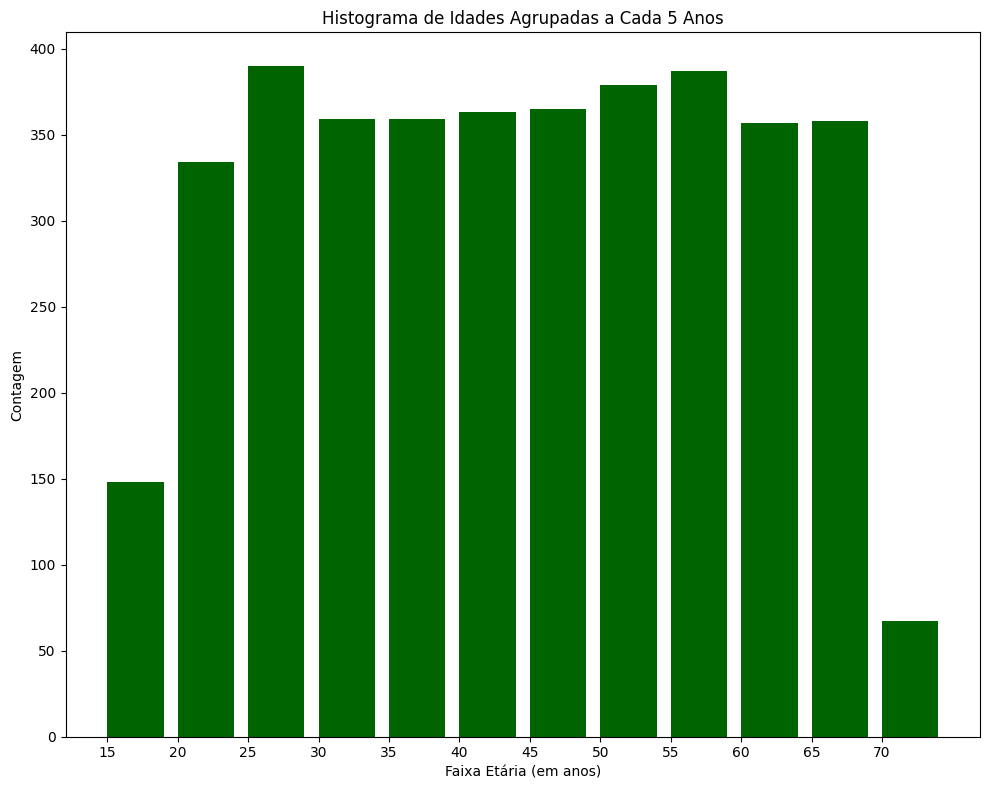

In [22]:
# Plotagem do histograma
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
plt.bar(age_groups, count, width=4, align='edge', color='darkgreen')
plt.xlabel('Faixa Etária (em anos)')
plt.ylabel('Contagem')
plt.title('Histograma de Idades Agrupadas a Cada 5 Anos')
plt.xticks(range(min(age_groups), max(age_groups) + 5, 5))

plt.tight_layout()

In [23]:
#Para a variável Age(idade), a partir dos 20 até os 65 anos , a quantidade de compras por idade dos clientes permanece estável.

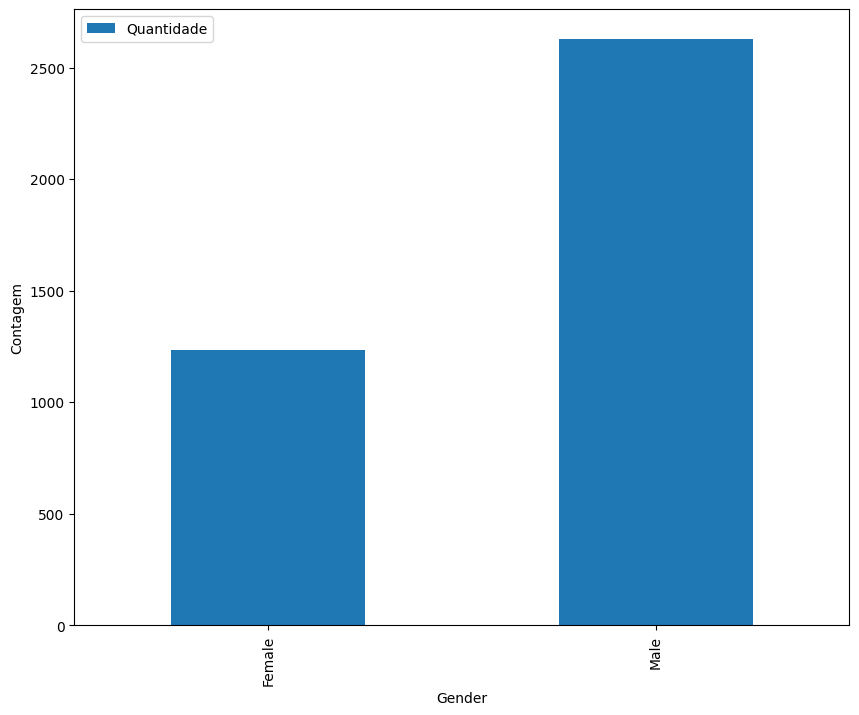

In [24]:
# Analisar quantidade de compras por gênero
gender = customer_analise.groupBy("Gender").agg(f.count("Customer ID").alias("Quantidade"))
gender.toPandas().set_index("Gender").plot(kind='bar', figsize=(10,8));
plt.ylabel('Contagem');

In [25]:
#Para a variável idade, existe uma diferença significativa entre o perfil de compras, sendo a maior parte composta pelo gênero Male (masculino)

In [26]:
#Estudo da variável Age x Gender
# Exemplo 2: Média de idade dos clientes por gênero
age_gender = customer_analise.groupBy("Gender").agg(f.count('Age'),
                                             f.avg("Age"),
                                             f.min('Age'),
                                             f.max('Age'))
age_gender.show()

+------+----------+------------------+--------+--------+
|Gender|count(Age)|          avg(Age)|min(Age)|max(Age)|
+------+----------+------------------+--------+--------+
|Female|      1236|43.970873786407765|      18|      70|
|  Male|      2630| 44.11634980988593|      18|      70|
+------+----------+------------------+--------+--------+



In [27]:
#Contagem de compras por temporada
compra_season = customer_analise.groupBy("Season").count()
compra_season.show()

+------+-----+
|Season|count|
+------+-----+
|Spring|  988|
|Summer|  948|
|  Fall|  963|
|Winter|  967|
+------+-----+



In [28]:
#Faturamento por temporada
faturamento_season = customer_analise.groupBy("Season").agg(f.sum('Purchase_Amount').alias('Faturamento'))
faturamento_season.show()

+------+-----------+
|Season|Faturamento|
+------+-----------+
|Spring|    57990.0|
|Summer|    55256.0|
|  Fall|    59276.0|
|Winter|    58364.0|
+------+-----------+



In [29]:
#Essa rede de shoppings tem uma quantidade de vendas perene ao longo do ano, com uma pequena queda no verão (summer).

In [30]:
#Análise de Category e Item_purchased

In [31]:
cube_category = customer_analise.cube('Category','item_purchased').agg(f.sum('Purchase_Amount').alias('Faturamento'),f.count('item_purchased').alias('Quantidade'))
cube_category.orderBy(cube_category.Faturamento.desc()).show()

+-----------+--------------+-----------+----------+
|   Category|item_purchased|Faturamento|Quantidade|
+-----------+--------------+-----------+----------+
|       NULL|          NULL|   230886.0|      3866|
|   Clothing|          NULL|   103246.0|      1722|
|Accessories|          NULL|    73449.0|      1227|
|   Footwear|          NULL|    35793.0|       595|
|  Outerwear|          NULL|    18398.0|       322|
|   Clothing|        Blouse|    10324.0|       170|
|       NULL|        Blouse|    10324.0|       170|
|   Clothing|         Dress|    10281.0|       165|
|       NULL|         Dress|    10281.0|       165|
|       NULL|         Shirt|    10166.0|       167|
|   Clothing|         Shirt|    10166.0|       167|
|   Clothing|         Pants|    10065.0|       170|
|       NULL|         Pants|    10065.0|       170|
|Accessories|       Jewelry|     9838.0|       167|
|       NULL|       Jewelry|     9838.0|       167|
|Accessories|          Belt|     9635.0|       161|
|       NULL

In [32]:
# Registrar o DataFrame como uma tabela temporária
customer_analise.createOrReplaceTempView("faturamento")

# Calcular a soma do "Purchase_Amount" e a quantidade_total agrupada por "Category"
query = """
SELECT Category,
       SUM(`Purchase_Amount`) AS total_faturado,
       COUNT(`item_purchased`) AS quantidade_total
  FROM faturamento
 GROUP BY Category
 ORDER BY quantidade_total
"""

total_category = spark.sql(query)


# Exibir o DataFrame resultante
total_category.show()

+-----------+--------------+----------------+
|   Category|total_faturado|quantidade_total|
+-----------+--------------+----------------+
|  Outerwear|       18398.0|             322|
|   Footwear|       35793.0|             595|
|Accessories|       73449.0|            1227|
|   Clothing|      103246.0|            1722|
+-----------+--------------+----------------+



In [33]:
total_category = total_category.withColumn("Total", total_category.total_faturado.cast("double"))
total_by_category = total_category.withColumn(
    "% do total",
    (total_category["total"] / total_category.agg({"Total": "sum"}).collect()[0][0]) * 100
).show()

+-----------+--------------+----------------+--------+------------------+
|   Category|total_faturado|quantidade_total|   Total|        % do total|
+-----------+--------------+----------------+--------+------------------+
|  Outerwear|       18398.0|             322| 18398.0| 7.968434638739465|
|   Footwear|       35793.0|             595| 35793.0|15.502455757386763|
|Accessories|       73449.0|            1227| 73449.0|31.811803227566855|
|   Clothing|      103246.0|            1722|103246.0| 44.71730637630692|
+-----------+--------------+----------------+--------+------------------+



In [34]:
#Clothing e Acessories representam juntos 75% do faturamento da rede de shopping

In [35]:
#Converter o dataframe em pandas spark
from pyspark import pandas as ps

# Ativar o suporte a Arrow para melhorar o desempenho
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

/content/spark-3.5.0-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [36]:
customer_pandas = customer_analise.toPandas()
type(customer_pandas)

pandas.core.frame.DataFrame

In [37]:
customer_pandas.head(3)

,Customer ID,Age,Gender,Item_Purchased,Category,Purchase_Amount,Location,Size,Color,Season,Review_Rating,Subscription_Status,Shipping_Type,Discount_Applied,Promo_Code_Used,Previous_Purchases,Payment_Method,Frequency_of_Purchases,Age_Group
0,1,55,Male,Blouse,Clothing,53.0,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,55
1,2,19,Male,Sweater,Clothing,64.0,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,15
2,3,50,Male,Jeans,Clothing,73.0,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,50


In [38]:
customer_pandas.describe()

,Customer ID,Age,Purchase_Amount,Review_Rating,Previous_Purchases,Age_Group
count,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000
mean,1949.609157,44.069840,59.722193,3.748655,25.345577,42.044749
std,1125.927560,15.216277,23.668165,0.716044,14.451904,15.289456
min,1.000000,18.000000,20.000000,2.500000,1.000000,15.000000
25%,974.250000,31.000000,39.000000,3.100000,13.000000,30.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000,40.000000
75%,2922.750000,57.000000,80.000000,4.400000,38.000000,55.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000,70.000000


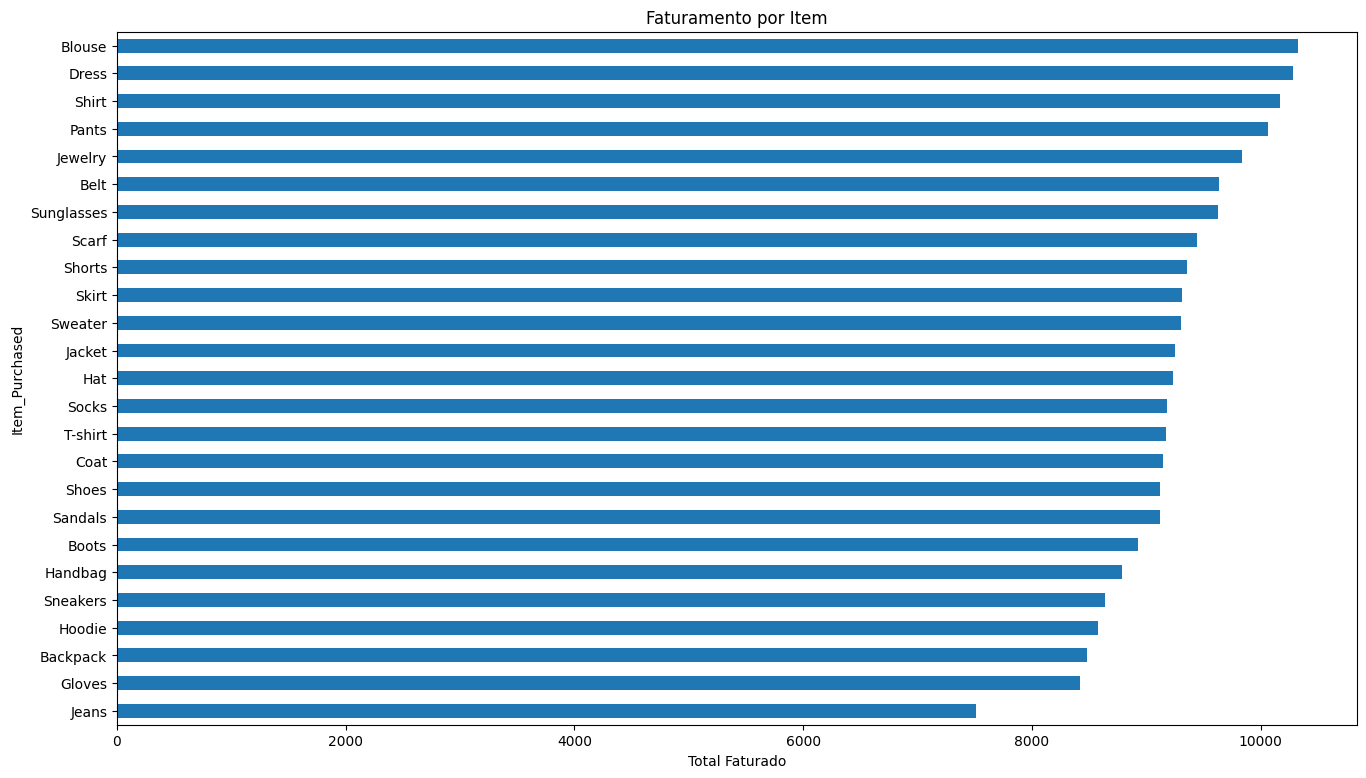

In [39]:
# Análise da variável Item_purchased por soma de faturamento
item_fat = customer_pandas.groupby('Item_Purchased').Purchase_Amount.sum()
item_fat.sort_values()[:30].plot(kind="barh", title = 'Faturamento por Item', figsize = (16,9), xlabel = 'Total Faturado');

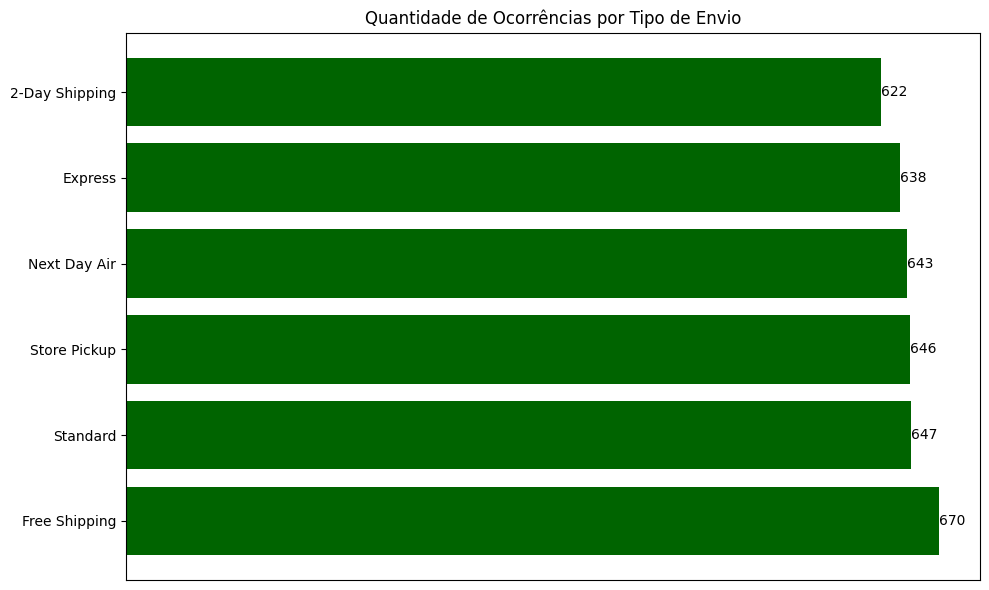

In [40]:
# Agrupe os dados por "Shipping Type" e calcule a contagem de ocorrências
shipping_counts = customer_pandas['Shipping_Type'].value_counts().reset_index()
shipping_counts.columns = ['Shipping_Type', 'Contagem']

# Plotagem do gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(shipping_counts['Shipping_Type'], shipping_counts['Contagem'], color='darkgreen')

# Adicione o número total na frente de cada barra
for index, row in shipping_counts.iterrows():
    plt.text(row['Contagem'], index, str(row['Contagem']), va='center')


plt.title('Quantidade de Ocorrências por Tipo de Envio')
plt.xticks([])

plt.tight_layout()

# Exibir o gráfico
plt.show()

In [41]:
# Calcule a correlação entre 'Shipping Type' e 'Review Rating'
correlation = customer_pandas['Shipping_Type'].astype('category').cat.codes.corr(customer_pandas['Review_Rating'])

# Exiba a correlação
print("Correlação entre Shipping Type e Review Rating:", correlation)

Correlação entre Shipping Type e Review Rating: -0.01101655523145375


In [42]:
#Media de Avaliações por Tipo de Envio
customer_pandas.groupby('Shipping_Type')['Review_Rating'].agg(['std','min' ,'mean', 'max'])

,std,min,mean,max
Shipping_Type,,,,
2-Day Shipping,0.709173,2.5,3.759646,5.0
Express,0.709946,2.5,3.776019,5.0
Free Shipping,0.709066,2.5,3.720597,5.0
Next Day Air,0.732215,2.5,3.719285,5.0
Standard,0.696401,2.5,3.813447,5.0
Store Pickup,0.735392,2.5,3.704489,5.0


In [43]:
#Não é possivel correlacionar uma nota mais alta de reviews ao tipo de envio.

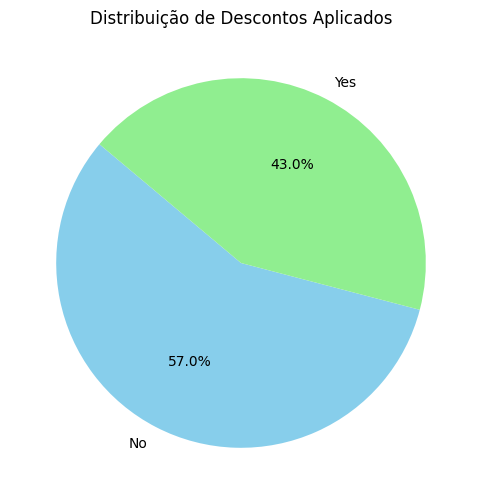

In [44]:
#Estudar a variável Discount Applied

# Contar as ocorrências de cada valor único em "Discount Applied"
discount_counts = customer_pandas['Discount_Applied'].value_counts()

# Plotar do gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(discount_counts, labels=discount_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightgreen'])

plt.title('Distribuição de Descontos Aplicados')

# Exibir o gráfico
plt.show()

In [45]:
#Calcular a correlação da variável Discount_Applied e Review Rating'
correlation_discount = customer_pandas['Discount_Applied'].astype('category').cat.codes.corr(customer_pandas['Review_Rating'])

# Exiba a correlação
print("Correlação entre Shipping Type e Review Rating:", correlation_discount)

Correlação entre Shipping Type e Review Rating: -0.013075702378260303


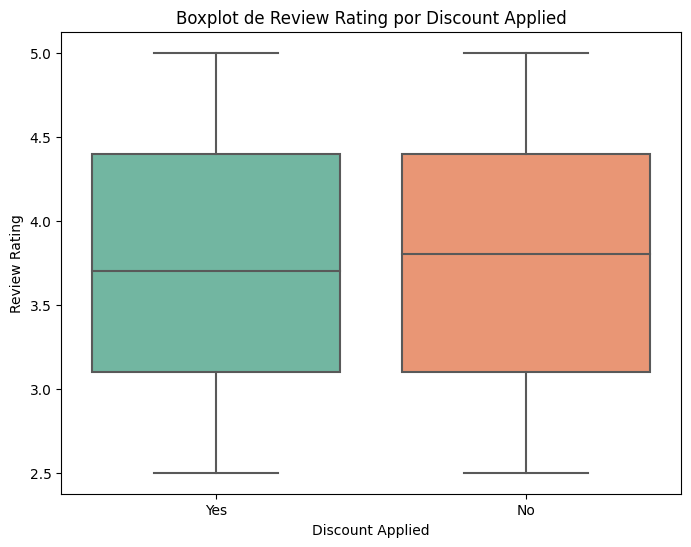

In [46]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Discount_Applied', y='Review_Rating', data=customer_pandas, palette='Set2')

# Ajuste as configurações do gráfico
plt.title('Boxplot de Review Rating por Discount Applied')
plt.xlabel('Discount Applied')
plt.ylabel('Review Rating')

# Exibir o gráfico
plt.show()

In [47]:
customer_pandas.groupby('Discount_Applied')[['Category']].value_counts()

Discount_Applied  Category   
No                Clothing       997
                  Accessories    691
                  Footwear       338
                  Outerwear      179
Yes               Clothing       725
                  Accessories    536
                  Footwear       257
                  Outerwear      143
dtype: int64

In [48]:
disc_categ = customer_pandas.groupby(['Category', 'Discount_Applied']).size().unstack(fill_value=0)

# Calcular o % da situação com ou sem desconto por categoria
disc_categ_percent = disc_categ.div(disc_categ.sum(axis=1), axis=0) * 100
print(disc_categ_percent)

Discount_Applied         No        Yes
Category                              
Accessories       56.316218  43.683782
Clothing          57.897793  42.102207
Footwear          56.806723  43.193277
Outerwear         55.590062  44.409938


In [49]:
#Não há uma categoria com maior desconto significativo do que outra

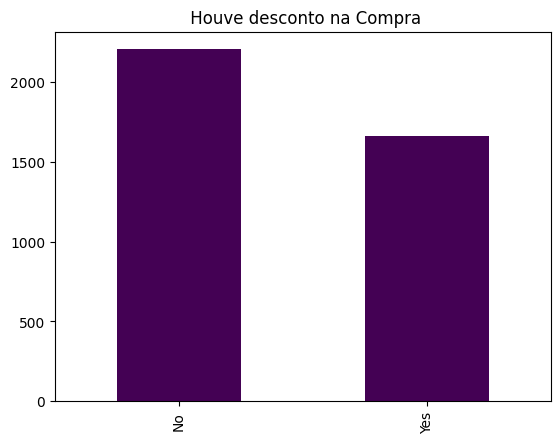

In [50]:
#Estudar a variável  Promo_Code_Used
customer_pandas['Promo_Code_Used'].value_counts().plot(kind = 'bar', title = ' Houve desconto na Compra', colormap = 'viridis');


In [51]:
promo_categ = customer_pandas.groupby(['Category', 'Promo_Code_Used']).size().unstack(fill_value=0)

# Calcular o % da situação com ou sem desconto por categoria
promo_categ_percent = round( promo_categ.div(disc_categ.sum(axis=1), axis=0) * 100,2)
print(promo_categ_percent)

Promo_Code_Used     No    Yes
Category                     
Accessories      56.32  43.68
Clothing         57.90  42.10
Footwear         56.81  43.19
Outerwear        55.59  44.41


In [52]:
#Análise de Preview Purchases x Payment Method
customer_pandas.groupby('Payment_Method')['Previous_Purchases'].agg(['min','mean','median','max'])

,min,mean,median,max
Payment_Method,,,,
Bank Transfer,1,24.464463,24.0,50
Cash,1,25.254491,25.0,50
Credit Card,1,25.543675,25.0,50
Debit Card,1,25.522152,25.0,50
PayPal,1,25.519403,26.5,50
Venmo,1,25.719298,26.0,50


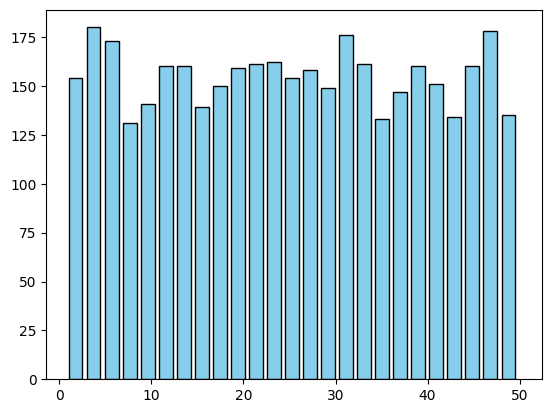

In [53]:
plt.hist(customer_pandas['Previous_Purchases'],width = 1.5, bins=25, color='skyblue', edgecolor='black');


In [54]:
novos = customer_pandas.query('Previous_Purchases <= 5')
intermediarios = customer_pandas.query('Previous_Purchases > 5 & Previous_Purchases <= 10')
fieis = customer_pandas.query('Previous_Purchases > 10')

In [55]:
total_count = len(customer_pandas)

# Calcular a proporção de cada categoria em relação ao total
proporcao_novos = len(novos) / total_count *100
proporcao_intermediarios = len(intermediarios) / total_count *100
proporcao_fieis = len(fieis) / total_count *100

# Exiba as proporções na tela
print(f'Proporção de Novos: {proporcao_novos:.2f}')
print(f'Proporção de Intermediários: {proporcao_intermediarios:.2f}')
print(f'Proporção de Fiéis: {proporcao_fieis:.2f}')

Proporção de Novos: 10.89
Proporção de Intermediários: 9.26
Proporção de Fiéis: 79.85


In [56]:
purc_freq = customer_pandas['Frequency_of_Purchases'].value_counts()

print(purc_freq)

Every 3 Months    579
Annually          568
Quarterly         558
Monthly           549
Bi-Weekly         542
Fortnightly       538
Weekly            532
Name: Frequency_of_Purchases, dtype: int64


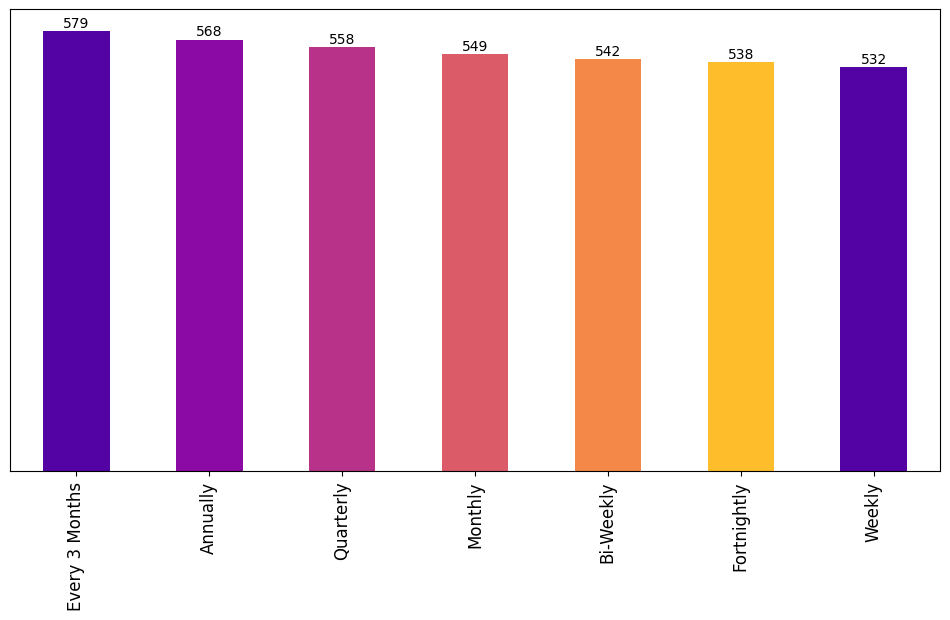

In [57]:
plt.figure(figsize = (12, 6))
ax = customer_pandas["Frequency_of_Purchases"].value_counts().plot(kind = 'bar' , color = sns.color_palette('plasma') )
plt.yticks([])
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1.5), ha = 'center', va = 'bottom', color = 'black')
    ax.tick_params(axis = 'both', labelsize = 12)

In [95]:
# Definir a função de transformação
def convert_frequency(value):
    conversion_rules = {
        'Monthly': 1,
        'Bi-Weekly': 1,
        'Fortnightly': 1,
        'Weekly': 1,
        'Every 3 Months': 0,
        'Annually': 0,
        'Quarterly': 0
    }
    return conversion_rules.get(value, None)

# Registrar a função como uma UDF
convert_frequency_udf = udf(convert_frequency, IntegerType())

# Aplicar a UDF à coluna 'Frequency of Purchases' para criar uma nova coluna
customer_analise = customer_analise.withColumn("Frequency_Purchase_Binary", convert_frequency_udf(customer_analise["Frequency_of_Purchases"]))

# Calcular a quantidade de 1 (compras frequentes) e 0 (compras não frequentes)
count_1 = customer_analise.filter(customer_analise["Frequency_Purchase_Binary"] == 1).count()
count_0 = customer_analise.filter(customer_analise["Frequency_Purchase_Binary"] == 0).count()


print("Quantidade de 1 (compras frequentes):", count_1)
print("Quantidade de 0 (compras não frequentes):", count_0)
print("% de clientes frequentes sobre o total:", (count_1 /( count_1 + count_0)*100))

Quantidade de 1 (compras frequentes): 2161
Quantidade de 0 (compras não frequentes): 1705
% de clientes frequentes sobre o total: 55.89756854630109


In [58]:
#Distribuição de quantidade de compras por localização

Estados = customer_pandas.groupby('Location').agg({'Customer ID': 'count', 'Purchase_Amount': 'sum'})
Estados= Estados.rename(columns={'Customer ID': 'Quantidade de Compras', 'Purchase_Amount': 'Total de Compras $'})


In [59]:
Estados.sort_values(by = 'Quantidade de Compras', ascending = False)

,Quantidade de Compras,Total de Compras $
Location,,
Montana,95,5761.0
California,95,5605.0
Idaho,93,5587.0
Illinois,89,5397.0
Minnesota,88,4977.0
Alabama,88,5215.0
New York,87,5257.0
Nevada,86,5475.0
Maryland,86,4795.0


In [60]:
customer_pandas = customer_pandas.drop('Age_Group', axis = 1)

In [61]:
customer_pandas = customer_pandas.drop('Customer ID', axis = 1)

<ipython-input-98-ed4d8319b57f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = customer_pandas.corr()


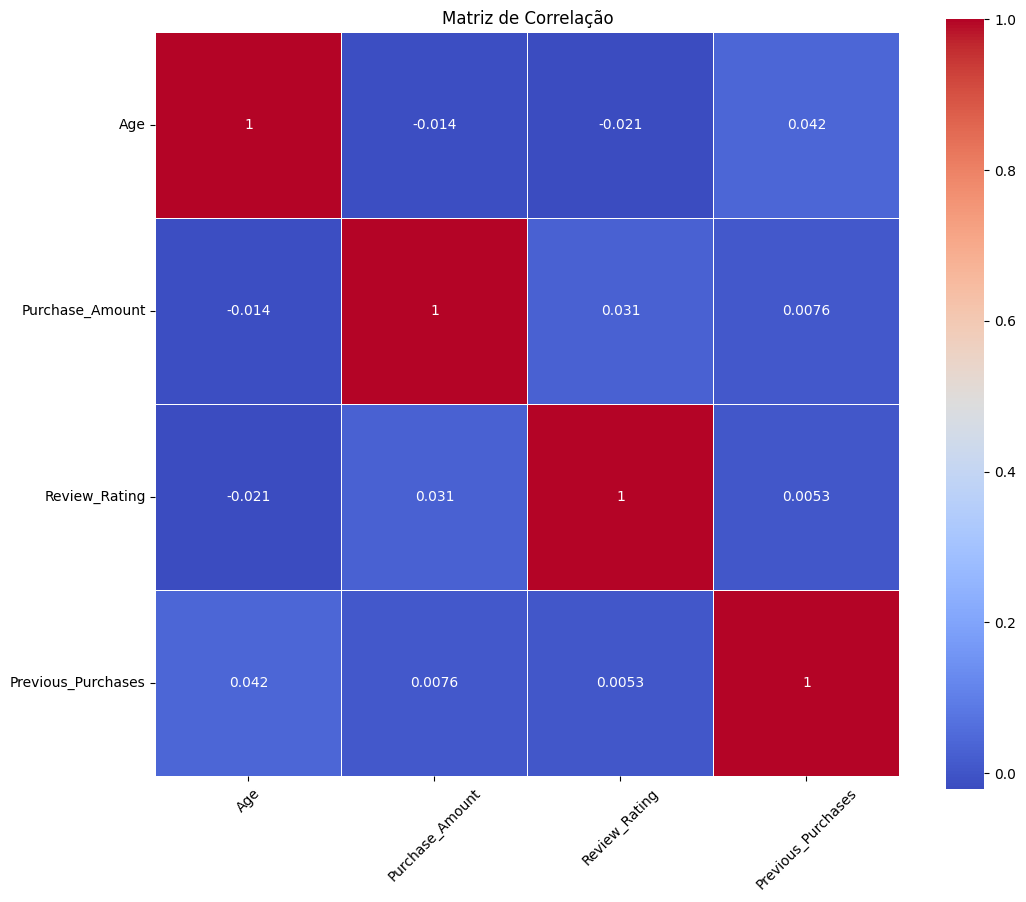

In [98]:
 #Calcular a matriz de correlação

correlation_matrix = customer_pandas.corr()

# Criar um mapa de calor (heatmap) da matriz de correlação usando Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)

# Ajustar as configurações do gráfico
plt.title('Matriz de Correlação')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

 #Exibir o gráfico
plt.show();

In [80]:
customer_pandas.duplicated().sum()

0